In [1]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import random
import matplotlib.pyplot as plt

T = 1.0
dT = T/12.0  # monthly simulation

# barrier
L = 150.0

# firm related
V0 = 200.0    # arbitrarily selectd
Debt = 175.0     # debt
recover = 0.25     # recovery rate
S0 = 100.0    # current share price
sigma_stock = 0.3     
sigma_firm = 0.3    
gamma = 0.75
corr = 0.2    # correlation between share value and firm value

# strike
K = S0      # at-the-money option

# Zero-coupon Bond
zcb_prices = np.array([99.38, 98.76, 98.15, 97.54, 96.94, 96.34, \
                       95.74, 95.16, 94.57, 93.99, 93.42, 92.85])
bond_face = 100.0


#### Calibrate initial forward rate

In [2]:
# calibrating with Vasicek model
months = np.linspace(1, 12.0, 12)*dT
bnds = ((0, 1.0), (0, 3), (0, 1.0), (0, 3))

def A(t1, t2, alpha):
    return (1-np.exp(-alpha*(t2-t1)))/alpha

def D(t1, t2, alpha, b, sigma):
    val1 = (t2-t1-A(t1, t2, alpha))*(sigma**2/(2*alpha**2)-b)
    val2 = sigma**2*A(t1, t2, alpha)**2/(4*alpha)
    return val1-val2

def bond_price_Vasi(r0, t, T, alpha, b, sigma):
    return np.exp(-A(t, T, alpha)*r0+D(t, T, alpha, b, sigma))

def F(x):
    r0 = x[0]
    alpha = x[1]
    b = x[2]
    sigma = x[3]
    return np.sum(np.abs(bond_price_Vasi(r0,0,months,alpha,b,sigma)*bond_face-zcb_prices))

# r0: initial forward rate
# r_alpha : mean reversion rate
# r_b:  long run mean forward rate
# r_sigma: volatility of forward rate
r0, r_alpha, r_b, r_sigma = opt.fmin_slsqp(F, (0.05, 0.3, 0.05, 0.3), bounds=bnds)


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.022545188277547368
            Iterations: 28
            Function evaluations: 202
            Gradient evaluations: 28


In [3]:
print("Calibrated initial forward rate is       ", r0)
print("Calibrated mean reversion rate is        ", r_alpha)
print("Calibrated long run mean forward rate is ", r_b)
print("Calibrated volatility of forward rate is ", r_sigma)

Calibrated initial forward rate is        0.07455670695423125
Calibrated mean reversion rate is         0.9150133506353277
Calibrated long run mean forward rate is  0.07697098184090224
Calibrated volatility of forward rate is  0.11656429817617553


#### Monte Carlo simulation
Stock price and firm value are recursively calculated by
$$ S_{t_{i+1}}=S_{t_i}e^{(r_{t_i}-\frac{\sigma^2(S_{t_i})^{2\gamma-2}}{2})\Delta t+\sigma (S_{t_i})^{\gamma-1}\sqrt{\Delta t}Z} $$

In [4]:
# calculate price at next time point
def next_price(dt, p0, sigma, r, Z):
    '''Generate N price path upto time t.
        dt :     time step
        p0 :    starting price
        sigma : volatility
        r :     forward rate
        Z :     normal random numbers
    '''
    vol = sigma*p0**(gamma-1)
    power = (r-vol**2/2)*dt+vol*np.sqrt(dt)*Z
    return p0*np.exp(power)


In [5]:
# Monte Carlo simulation

# First initialize data structure
np.random.seed(0)
n_spl = 100000
LIBOR_frate = np.array([[r0]*13]*n_spl)
stock_price = np.array([[S0]*13]*n_spl)
firm_value  = np.array([[V0]*13]*n_spl)

# simulation time points
t  = np.linspace(0, 1, 13)   # monthly simulation
dt = np.ones([n_spl, 12])*(t[1:]-t[:-1])

# generate random normal numbers, note Z_stock and Z_firm are correlated
Z_LIBOR = norm.rvs(size=[n_spl, 12])
Z_stock = norm.rvs(size=[n_spl, 12])
Z_firm  = corr*Z_stock + np.sqrt(1-corr**2)*norm.rvs(size=[n_spl, 12])

# iteratively simulate price path and LIBOR forward rate
for i in range(int(T/dT)):
    # first determine LIBOR rate
    mu_hat = np.cumsum(dt[:,i:]*LIBOR_frate[:,i+1:]*r_sigma**2/(1+dt[:,i:]*LIBOR_frate[:,i+1:]), axis = 1)
    LIBOR_frate[:,i+1:] = LIBOR_frate[:,i+1:]* \
                         np.exp((mu_hat-r_sigma**2/2)*dT+r_sigma*np.sqrt(dT)*Z_LIBOR[:,i:])
    # convert LIBOR rate to continuously compounded rate
    compound_rate = np.log(LIBOR_frate[:,i+1]*dt[:,i]+1)
    # calculate stock price next month
    stock_price[:,i+1] = next_price(dT, stock_price[:,i], sigma_stock, compound_rate, Z_stock[:,i])
    # firm value next month
    firm_value[:,i+1]  = next_price(dT, firm_value[:,i], sigma_firm, compound_rate, Z_firm[:,i])
    

#### Discount Factor

In [6]:
discount_factor = np.mean(1.0/np.cumprod(1+dt*LIBOR_frate[:,1:], axis =1), axis=0)

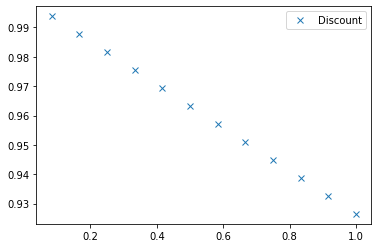

In [7]:
plt.plot(t[1:], discount_factor, 'x', label='Discount')
plt.legend()
plt.show()

#### Up-and-Out Call option price

In [8]:
# define the payoff of call option
def payoff(price, K, L):
    if price.any() >= L:
        return 0
    else:
        return np.maximum(price[-1]-K, 0)

# calculate payoff for all price path
def payoff_without_risk_adj(price_paths, K, L):
    """Calculating the payoff of up-and-out call option given a share price path, barrier L and strike K."""
    return np.array([payoff(path, K, L) for path in price_paths])

# calculate the amount lost due to default risk, on each path
def amount_lost(share_path, firm_value, K, L, debt):
    payoff_on_path = payoff_without_risk_adj(share_path, K, L)
    return np.array([discount_factor[-1]*(1-recover)*(term_firm_val<debt)*call_val \
                     for term_firm_val, call_val in \
                     zip(firm_value[:,-1], payoff_on_path )])
    

In [9]:
call_ignore_default_risk = np.mean(payoff_without_risk_adj(stock_price, K, L))
call_with_default_risk = call_ignore_default_risk - np.mean(amount_lost(stock_price, firm_value, K, L, Debt))

In [10]:
print("The price for Up-and-Out call option :")
print("    Ignoring default risk    ", call_ignore_default_risk)
print("    Considerting default risk", call_with_default_risk)

The price for Up-and-Out call option :
    Ignoring default risk     4.113262043496624
    Considerting default risk 4.0434272909262114
